### 1. Descomposición LU

In [55]:
def descompLU(A, b):
    """Realiza la descomposición LU
    
    El parametro b no es utulizado.
    """
    # Obtenemos el numero de filas
    n = len(A)

    # Llenamos la diagonal de la matriz L con 1
    L = [[0 if i!=j else 1 for j in range(n)] for i in range(n)]
    
    # Igualamos U a la matriz A
    # No copiamos directamente con U = A por que cualquier alteracion
    # en U tambien alterará las componentes de A
    U = [[A[i][j] for j in range(n)] for i in range(n)]
    
    for i in range(0, n):
        # Para cada fila i, accedemos a la columna i+1 hasta el final
        # y dividimos por el coefiente diagonal A(k ,k)
        for k in range(i+1, n):
            L[k][i] = U[k][i] / U[i][i]
            
            # Para cada fila desde i+i hasta el final, realizamos
            # eliminacion Gausiana. Al final preservaremos solo 
            # la diagonal superior de A.
            for l in range(i+1, n):
                U[k][l] = U[k][l] - L[k][i] * U[i][l]
                
    U = [[U[i][j] if i<=j else 0 for j in range(n)] for i in range(n)]
    
    return L, U

In [56]:
def printMatrix(M, matrix_name='M'):
    m = len(M)
    n = len(M[0])
    
    print("{0} = [".format(matrix_name))
    for i in range(m):
        print("    [", end='')
        for j in range(n):
            print("{0:11.6f}".format(M[i][j]), end='')
        print("]")
    print("]")

In [57]:
from random import random
from scipy import matmul

n = 3
A = [[20*random() for j in range(n)] for i in range(n)]
b = [20*random() for i in range(n)]

L, U = descompLU(A, b)

printMatrix(A, 'A')
print()
printMatrix(L, 'L')
print()
printMatrix(U, 'U')
print()
printMatrix(matmul(L, U), 'LU')

A = [
    [   3.452979   3.238592  15.608785]
    [  11.666701   9.214550   0.409227]
    [   2.415566   4.245479  14.264606]
]

L = [
    [   1.000000   0.000000   0.000000]
    [   3.378735   1.000000   0.000000]
    [   0.699560  -1.145905   1.000000]
]

U = [
    [   3.452979   3.238592  15.608785]
    [   0.000000  -1.727795 -52.328720]
    [   0.000000   0.000000 -56.618408]
]

LU = [
    [   3.452979   3.238592  15.608785]
    [  11.666701   9.214550   0.409227]
    [   2.415566   4.245479  14.264606]
]


### 2. Interpolación de Richarson

In [58]:
def dRich(f, x, s, n, h):
    # Llenamos la matriz de extrapolacion con ceros
    D = [[0 for j in range(n+1)] for i in range(n+1)]

    # Llenamos la primera columna con las formulas 
    # de diferencias centrales
    for i in range(n+1):
        D[i][0] = (f(x + h) - 2 * f(x) + f(x-h)) / (h**2)
        
        if s == 'central':
            powerOf4 = 1
            
            for j in range(1, i+1):
                powerOf4 = 4 * powerOf4
                D[i][j] = D[i][j-1] + ( D[i][j-1] - D[i-1][j-1] ) / ( powerOf4 - 1 )

        elif s == 'forward':
            powerOf2 = 1

            for j in range(1, i+1):
                powerOf2 = 2 * powerOf2
                D[i][j] = D[i][j-1] + ( D[i][j-1] - D[i-1][j-1] ) / ( powerOf2 - 1 )
        else:
            raise(ValueError("Value of `s' parameter must be one of `cental' or `forward'"))
        h = 0.5 * h

    return D[n][n]

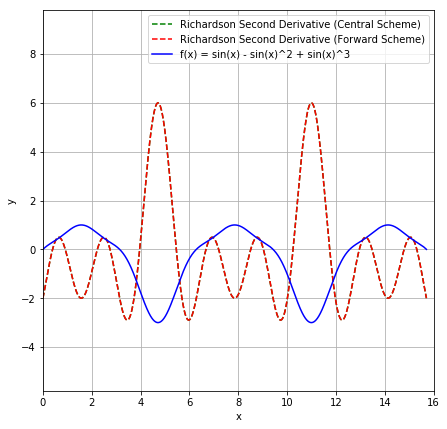

In [59]:
from math import pi
from math import sin
from math import ceil
from matplotlib import pylab

def f(x):
    s = sin(x)  
    return s - s**2 + s**3

m = 3001
Xmin = 0
Xmax = 5*pi
Xstep = (Xmax - Xmin) / (m - 1)
X = [Xmin + i*Xstep for i in range(0, m)]
Y = [f(x) for x in X]

n = 10
h = Xstep

s = 'central'
DC2Y = [dRich(f, x, s, n, Xstep) for x in X]

s = 'forward'
DF2Y = [dRich(f, x, s, n, Xstep) for x in X]

pylab.figure(figsize=(7,7))
pylab.plot(X,DC2Y, 'g--', label='Richardson Second Derivative (Central Scheme)')
pylab.plot(X,DF2Y, 'r--', label='Richardson Second Derivative (Forward Scheme)')
pylab.plot(X,Y, 'b-', label='f(x) = sin(x) - sin(x)^2 + sin(x)^3')
pylab.gca().set_aspect('equal', 'datalim')
pylab.xlabel('x')
pylab.xlim([0,ceil(Xmax)])
pylab.ylabel('y')
pylab.ylim([-4,8])
pylab.legend()
pylab.grid()
pylab.show()

### 3. Richardson Integration

In [60]:
def iRich(f, a, b, e):
    R = []
    h = b - a
    R.append([0.5 * h * ( f( a ) + f( b ) )])
    E = [0]
    
    i = 0
    powerOf2 = 1

    while(True):
        i = i + 1
        
        # Calculamos la mitad del paso en x y usamos este valor para sumar la 
        # función en todos los nuevos puntos (en medio de los puntos ya
        # calculados)
        h = 0.5 * h
        sum = 0.0
        powerOf2 = 2 * powerOf2
        
        for k in range(1, powerOf2, 2):
            sum = sum + f(a + k * h)
        
        # Calculamos la regla compuesta del trapecio para el siguiente
        # nivel de subdivisión. Usamos la regla de Richarson para refinar 
        # estos valores en una forma mas adecuada.
        R.append([])
        R[-1].append(0.5 * R[i-1][0] + sum * h)
        
        # Verificar si el algoritmo fallará
        if i > 2:
            E[i-1] = (R[i-2][0] - R[i-1][0]) / (R[i-1][0] - R[i][0])
            # Hacer la condición explicita
            # if E[i-1]:
            #     break
            
        powerOf4 = 1
        for j in range(1, i + 1):
            powerOf4 = 4 * powerOf4
            R[-1].append(R[i][j-1] + (R[i][j-1] - R[i-1][j-1]) / (powerOf4 - 1))
        
        E.append(0)
            
        if i >= 5 and e >= abs(R[i][i] - R[i-1][i-1]):
            break 
            
    return E, R

In [61]:
from math import pi
from math import sin
from math import exp

def f(x):
    return 1.0 / ((x**2) + 1) + exp(-x) - 2**sin(5*x) + 2

e, r = iRich(f, 0, 2, 0.00000000001)

In [62]:
for t, row in zip(e, r):
    print("{0: >11.8f} ".format(t), end="")
    
    for item in row:
        print("{0: >11.8f} ".format(item), end="")
    print()

 0.00000000  4.64947868 
 0.00000000  4.67817842  4.68774501 
11.45211507  3.59277446  3.23097314  3.13385501 
 3.93480310  3.49799686  3.46640433  3.48209974  3.48762743 
 3.99764596  3.47390986  3.46588086  3.46584596  3.46558797  3.46550154 
 4.00222633  3.46788457  3.46587613  3.46587582  3.46587629  3.46587742  3.46587779 
 4.00076482  3.46637908  3.46587725  3.46587732  3.46587735  3.46587735  3.46587735  3.46587735 
 4.00020356  3.46600278  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735 
 4.00005165  3.46590871  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735 
 0.00000000  3.46588519  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735  3.46587735 


In [63]:
from math import pi
from math import cos
from math import log

def f(x):
    return log(1+x) - x**2 + abs(cos(x**4))

e, r = iRich(f, 0, 2, 0.001)

In [64]:
for t, row in zip(e, r):
    print("{0: >11.8f} ".format(t), end="")
    
    for item in row:
        print("{0: >11.8f} ".format(item), end="")
    print()

 0.00000000 -0.94372823 
 0.00000000 -0.23841463 -0.00331010 
 0.70086887 -0.03780459  0.02906542  0.03122379 
28.02812602  0.24842590  0.34383606  0.36482077  0.37011596 
-0.08782135  0.25863815  0.26204224  0.25658932  0.25487136  0.25441942 
-5.33719093  0.14235369  0.10359220  0.09302886  0.09043267  0.08978781  0.08962688 
 8.17334694  0.16414127  0.17140379  0.17592457  0.17724037  0.17758079  0.17766661  0.17768811 
10.86780916  0.16680695  0.16769552  0.16744830  0.16731375  0.16727482  0.16726475  0.16726221  0.16726157 
 0.00000000  0.16705224  0.16713400  0.16709656  0.16709098  0.16709011  0.16708992  0.16708988  0.16708987  0.16708987 


### 4. Gauss Jordan

In [101]:
def elimGJ(A, B):
    n = len(A)
    if n != len(A[0]):
        raise ValueError("Matrix A must be square")
        
    if n != len(B):
        raise ValueError("Matrix A and B are not compatible")
    
    try:
        bVectors = list(map(list, zip(*B)))
    except:
        bVectors = [B]
        
    xVectors = []
    
    for b in bVectors:
        m = [[A[i][j] for j in range(n)] for i in range(n)]
        
        for rowH, bItem in zip(m,b):
            rowH.append(bItem)
    
        h, w = len(m), len(m[0])
        
        for y in range(h):
            # Eliminamos la columna Y
            for y2 in range(y + 1, h):
                c = m[y2][y] / m[y][y]
                for x in range(y, w):
                    m[y2][x] -= m[y][x] * c
        for y in range(h-1, 0-1, -1): # Backsubstitute
            c    = m[y][y]
            for y2 in range(0,y):
                for x in range(w-1, y-1, -1):
                    m[y2][x] -=    m[y][x] * m[y2][y] / c
            m[y][y] /= c
            for x in range(h, w):             # Normalize row y
                m[y][x] /= c
        
        xVectors.append([])
        
        for row in m:
            xVectors[-1].append(row[-1]);
            
    if len(xVectors) == 1:
        return xVectors[0]
    
    return list(map(list, zip(*xVectors)))

In [131]:
def printMatrix(M, matrix_name='M'):
    m = len(M)
    n = len(M[0])
    
    print("{0} = [".format(matrix_name))
    for i in range(m):
        print("    [", end='')
        for j in range(n):
            print("{0:11.6f}".format(M[i][j]), end='')
        print("]")
    print("]")

In [132]:
def printVector(M, vector_name='M'):
    m = len(M)
    
    print("{0} = [".format(vector_name))
    for i in range(m):
        print("{0:11.6f}".format(M[i]))
    print("]")

In [133]:
A = [
    [1.0,2.0,4.0],
    [1.0,3.0,0.0],
    [1.0,5.0,5.0]
]

B = [
    [5.0, 8.0],
    [1.0, 2.0],
    [3.0, 3.0]
]

X1, X2 = zip(*elimGJ(A,B))

printMatrix(A, 'A')
printMatrix(B, 'B')
printVector(X1, 'X1')
printVector(X2, 'X2')
printVector(matmul(A, X1), 'A * X1')
printVector(matmul(A, X2), 'A * X2')

A = [
    [   1.000000   2.000000   4.000000]
    [   1.000000   3.000000   0.000000]
    [   1.000000   5.000000   5.000000]
]
B = [
    [   5.000000   8.000000]
    [   1.000000   2.000000]
    [   3.000000   3.000000]
]
X1 = [
   3.769231
  -0.923077
   0.769231
]
X2 = [
   8.000000
  -2.000000
   1.000000
]
A * X1 = [
   5.000000
   1.000000
   3.000000
]
A * X2 = [
   8.000000
   2.000000
   3.000000
]


In [134]:
A = [
    [1., 2., 3.],
    [4., 5., 6.],
    [1., 0., 1.]
]

B = [1., 1., 1.]

X = elimGJ(A,B)

printMatrix(A, 'A')
printVector(B, 'B')
printVector(X, 'X')
printVector(matmul(A, X), 'A * X')

A = [
    [   1.000000   2.000000   3.000000]
    [   4.000000   5.000000   6.000000]
    [   1.000000   0.000000   1.000000]
]
B = [
   1.000000
   1.000000
   1.000000
]
X = [
   0.000000
  -1.000000
   1.000000
]
A * X = [
   1.000000
   1.000000
   1.000000
]
